In [1]:
import os

os.getcwd()

'/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__'

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# import PyNIO as Nio
import pandas as pd
import glob
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from scipy.optimize import curve_fit
import seaborn as sns
from copy import deepcopy
from useful_func_cy import *

### Fig 8:
Latitudinal constraints on 40^{o}S-50^{o}S and 50^{o}S-85^{o}S SW_FB by Equation 1:

In [3]:
# Read CMIP5/ 6 Cloud feedbacks data:

fn_cmip5 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/CMIP5_cld_fbks.nc'

fn_cmip6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/CMIP6_cld_fbkd_July12.nc'

# glob.glob(fn_cmip5)
f_cmip5 = nc.Dataset(fn_cmip5, 'r')

f_cmip6 = nc.Dataset(fn_cmip6, 'r')

print(f_cmip5.variables['model'])

<class 'netCDF4._netCDF4.Variable'>
float64 model(model)
    realtopology: linear
    long_name: ['ACCESS1-0' 'ACCESS1-3' 'BNU-ESM' 'CCSM4' 'CNRM-CM5' 'CSIRO-Mk3-6-0'
 'CanESM2' 'FGOALS-g2' 'FGOALS-s2' 'GFDL-CM3' 'GFDL-ESM2G' 'GFDL-ESM2M'
 'GISS-E2-H' 'GISS-E2-R' 'HadGEM2-ES' 'IPSL-CM5A-LR' 'IPSL-CM5A-MR'
 'IPSL-CM5B-LR' 'MIROC-ESM' 'MIROC5' 'MPI-ESM-LR' 'MPI-ESM-MR' 'MPI-ESM-P'
 'MRI-CGCM3' 'NorESM1-M' 'NorESM1-ME' 'bcc-csm1-1-m' 'bcc-csm1-1' 'inmcm4']
unlimited dimensions: 
current shape = (29,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [4]:
# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

path_data = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path_plot = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/plot_file/'

In [5]:
# variables from Zelinka's SWfb files:

lat_mz = np.asarray(f_cmip6.variables['latitude'])
bound_lat_mz = np.asarray(f_cmip6.variables['bounds_latitude'])

lon_mz = np.asarray(f_cmip6.variables['longitude'])
bound_lon_mz = np.asarray(f_cmip6.variables['bounds_longitude'])
# print(lon_mz)

# model_names:
cmip6model_nas = f_cmip6.variables['model'].long_name
cmip5model_nas = f_cmip5.variables['model'].long_name

cmip6_nas = cmip6model_nas[1:-1].split()
for i in range(len(cmip6_nas)):
    cmip6_nas[i] = cmip6_nas[i][1:-1]
    
cmip5_nas = cmip5model_nas[1:-1].split()
for i in range(len(cmip5_nas)):
    cmip5_nas[i] = cmip5_nas[i][1:-1]
# print(cmip6_nas)
# print(cmip5_nas)

model_nas = []
model_nas = np.append(cmip6_nas, cmip5_nas)
print(model_nas.shape)

# SW_cloud_Feedback:
sw_cld_fb_mz = []
cmip6_sw_cld_fb_mz = np.asarray(f_cmip6.variables['SWCLD_fbk6_map'])

cmip5_sw_cld_fb_mz = np.asarray(f_cmip5.variables['SWCLD_fbk5_map'])

sw_cld_fb_mz = np.append(cmip6_sw_cld_fb_mz, cmip5_sw_cld_fb_mz, axis =2)
print(sw_cld_fb_mz.shape)


(79,)
(90, 144, 79)


In [6]:
# Southern Ocean sw_cloud_FB :
lati0 = -85.
latsi0 = min(range(len(lat_mz)), key = lambda i: abs(lat_mz[i] - lati0))
lati1 = -40.
latsi1 = min(range(len(lat_mz)), key = lambda i: abs(lat_mz[i] - lati1))
lati2 = -50.
latsi2 = min(range(len(lat_mz)), key = lambda i: abs(lat_mz[i] - lati2))

print("latitude index for -85.s -40.s and -50.s:", latsi0, latsi1, latsi2)
# print(lat_mz[latsi0], lat_mz[latsi1+1], lat_mz[latsi2+1])

# Handle nan value
sw_cld_fb_mz = np.where(sw_cld_fb_mz!=1.e+20, sw_cld_fb_mz, np.nan)
ind_nan = np.isnan(sw_cld_fb_mz)
# print(np.nonzero(ind_nan==True))  # #0

# SO_sw_cldfb
# SO_sw_cldfb = np.nanmean(sw_cld_fb_mz[(latsi0+1):(latsi1+1),:,:], axix = (0, 1)) # -84.S ~ -40.S

# x_range & y_range:
y_range_swcld = lat_mz[(latsi0):(latsi1+1+1)]
y_range_swcld4050 = lat_mz[(latsi2+1):(latsi1+1+1)]
y_range_swcld5085 = lat_mz[(latsi0):(latsi2+1+1)]
x_range_swcld = lon_mz

print(y_range_swcld, y_range_swcld4050)

reshape_sw_cld_fb = np.transpose(sw_cld_fb_mz,(2, 0, 1))
# SO_sw_cldfb = area_mean(reshape_sw_cld_fb[:,(latsi0):(latsi1+1+1),:], y_range_swcld, x_range_swcld) # -85.S ~ -40.S
SO_sw_cldfb = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-85., -40.])
# SO_sw_cldfb_5085 = area_mean(reshape_sw_cld_fb[:,(latsi0):(latsi2+1+1),:], y_range_swcld5085, x_range_swcld) # -85.S ~ -50.S
SO_sw_cldfb_5085 = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-85., -50.])
# SO_sw_cldfb_4050 = area_mean(reshape_sw_cld_fb[:,(latsi2+1):(latsi1+1+1),:], y_range_swcld4050, x_range_swcld) # -50.S ~ -40.S
SO_sw_cldfb_4050 = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-50., -40.])

print(SO_sw_cldfb_4050)


latitude index for -85.s -40.s and -50.s: 2 24 19
[-85. -83. -81. -79. -77. -75. -73. -71. -69. -67. -65. -63. -61. -59.
 -57. -55. -53. -51. -49. -47. -45. -43. -41. -39.] [-49. -47. -45. -43. -41. -39.]
[ 2.0267079   0.4895854   0.32520095  1.68404732  1.40920963  0.01748841
  3.01992467  4.05619034  3.37416672  4.65445625  2.23892258  2.27406274
  2.26810595  0.70997683  0.69514791  0.51087387  0.16375956  1.52204054
  0.33433327  0.39355196  0.22759463  0.32813533  0.05186628  1.00712129
  0.99107601  0.17406289  0.23418182  0.0607906   2.13181006  2.06512805
 -0.567081   -0.31427254 -0.6226619   1.29273295  0.52788332  0.66441757
  2.16760429 -0.04580202 -0.63837113  0.01544427  0.41359124 -0.46313321
  0.59094719  0.49275878  0.76045721  0.49658004  0.26264515  3.2801037
  4.1567331   1.99205367  0.13412499  0.27582606  0.84574391  1.15888771
 -0.66135967  0.19070553 -0.14875279  0.05671836  0.99959534  0.80217849
 -0.62163003 -0.54235909  0.37048835  0.64213055  0.17225141  1.34

In [7]:
lat_mz = np.asarray(f_cmip6.variables['latitude'])
bound_lat_mz = np.asarray(f_cmip6.variables['bounds_latitude'])

# print(np.asarray(lat_mz).shape)
# print(np.asarray(bound_lat_mz))

In [8]:
# model list

exp = 'piControl'

# CMIP6: 31 (30: BCCCSMCM2MR)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: 20 (18, ACCESS10, ACCESS13)
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROCESM = {'modn': 'MIROC-ESM', 'consort': 'MIROC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MRICGCM3 = {'modn': 'MRI-CGCM3', 'consort': 'MRI', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMLR = {'modn': 'MPI-ESM-LR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
bcccsm11 = {'modn': 'bcc-csm1-1', 'consort': 'BCC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2G = {'modn': 'GFDL-ESM2G', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2M = {'modn': 'GFDL-ESM2M', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

# cmip5 + cmip6 (50):

deck2 = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM21, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0, E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1, INM_CM48, MPIESM12LR, AWICM11MR, CMCCCM2SR5, CESM2WACCMFV2, CNRMCM61, CNRMCM61HR, ECEarth3, ECEarth3Veg, GISSE22G, MIROCES2L, NESM3, NorESM2MM, TaiESM1, BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M, MIROCESM, MRICGCM3, MPIESMLR, bcccsm11, GFDLESM2G, GFDLESM2M]  # current # 30 + 20 = 50
deck_nas2 = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM21', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0', 'E3SM10', 'FGOALSg3', 'GFDLCM4', 'CAMSCSM1', 'INM_CM48', 'MPIESM12LR', 'AWICM11MR', 'CMCCCM2SR5', 'CESM2WACCMFV2', 'CNRMCM61', 'CNRMCM61HR', 'ECEarth3', 'ECEarth3Veg', 'GISSE22G', 'MIROCES2L', 'NESM3', 'NorESM2MM', 'TaiESM1', 'BNUESM', 'CCSM4', 'CNRMCM5', 'CSIRO_Mk360', 'CanESM2', 'FGOALSg2', 'FGOALSs2', 'GFDLCM3', 'GISSE2H', 'GISSE2R', 'IPSLCM5ALR', 'MIROC5', 'MPIESMMR', 'NorESM1M', 'MIROCESM', 'MRICGCM3', 'MPIESMLR', 'bcccsm11', 'GFDLESM2G', 'GFDLESM2M']  # current # 30 + 20 = 50

deck3 = [CanESM5, E3SM10, CESM2FV2, CESM2, CNRMCM61, CESM2WACCMFV2, CNRMESM21, NESM3, IPSLCM6ALR, CESM2WACCM, MIROCESM, TaiESM1, ECEarth3Veg, CNRMCM61HR, ECEarth3, 
         FGOALSs2, IPSLCM5ALR, CSIRO_Mk360, BNUESM, GFDLCM3, GFDLCM4, SAM0, CanESM2, MPIESMLR, CMCCCM2SR5, MPIESMMR, FGOALSg2, BCCESM1, CNRMCM5, AWICM11MR, MRIESM20, 
          GISSE21H, MPIESM12LR, CCSM4, NorESM1M, FGOALSg3, bcccsm11, MIROC5, GISSE21G, MIROCES2L, MRICGCM3, MIROC6, NorESM2MM, GFDLESM2M, GFDLESM2G, GISSE22G, GISSE21H, CAMSCSM1, GISSE2R, INM_CM48]
deck3_nas = ['CanESM5', 'E3SM10', 'CESM2FV2', 'CESM2', 'CNRMCM61', 'CESM2WACCMFV2', 'CNRMESM21', 'NESM3', 'IPSLCM6ALR', 'CESM2WACCM', 'MIROCESM', 'TaiESM1', 'ECEarth3Veg', 'CNRMCM61HR', 'ECEarth3', 
         'FGOALSs2', 'IPSLCM5ALR', 'CSIRO_Mk360', 'BNUESM', 'GFDLCM3', 'GFDLCM4', 'SAM0', 'CanESM2', 'MPIESMLR', 'CMCCCM2SR5', 'MPIESMMR', 'FGOALSg2', 'BCCESM1', 'CNRMCM5', 'AWICM11MR', 'MRIESM20', 
          'GISSE21H', 'MPIESM12LR', 'CCSM4', 'NorESM1M', 'FGOALSg3', 'bcccsm11', 'MIROC5', 'GISSE21G', 'MIROCES2L', 'MRICGCM3', 'MIROC6', 'NorESM2MM', 'GFDLESM2M', 'GFDLESM2G', 'GISSE22G', 'GISSE21H', 'CAMSCSM1', 'GISSE2R', 'INM_CM48']

In [9]:
## Read two Regimes (Warm, Cold) data

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT = {}
output_2lrm_predict = {}  # dict, store annualy, area_meaned prediction of LWP
output_2lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs LWP
output_2lrm_coef_LWP = {}
output_2lrm_dict_Albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_2lrm_dict_albedo_lL = {}

# Raw data
output_2lrm_yr_bin_abr = {}
output_2lrm_yr_bin_PI = {}
output_2lrm_mon_bin_abr = {}
output_2lrm_mon_bin_PI = {}

# Metric raw data in specific units:
shape_mon_pi = {}
shape_mon_abr = {}
output_2lrm_metric_actual_PI = {}
output_2lrm_metric_actual_abr = {}

# Statistic metrics of PI:
output_Mean_training = {}
output_Stdev_training = {}

# Predict metric data in specific units:
output_2lrm_mon_bin_LWPpredi_PI = {}
output_2lrm_mon_bin_LWPpredi_abr = {}
output_2lrm_DxDtG = {}

# Index for regime(s): Only for 2lrm
output_ind_Cold_PI = {}
output_ind_Hot_PI = {}
output_ind_Cold_abr = {}
output_ind_Hot_abr = {}

Tr_sst =  0.0

for i in range(len(deck3)):
    # print("i", i)
    # folder_2lrm = glob.glob(path_data+deck3[i]['modn'] + '_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies' + '*' + '_dats.npz')
    
    folder_2lrm = glob.glob(path_data+deck3[i]['modn'] + '_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest' + '*' + '_dats.npz')
    print(len(folder_2lrm))
    
    if len(folder_2lrm) == 5:
        if (len(folder_2lrm[0]) < len(folder_2lrm[1])) & (len(folder_2lrm[0]) < len(folder_2lrm[2])) & (len(folder_2lrm[0]) < len(folder_2lrm[3])) & (len(folder_2lrm[0]) < len(folder_2lrm[4])):
            folder_best2lrm = folder_2lrm[0]
        elif (len(folder_2lrm[1]) < len(folder_2lrm[0])) & (len(folder_2lrm[1]) < len(folder_2lrm[2])) & (len(folder_2lrm[1]) < len(folder_2lrm[3])) & (len(folder_2lrm[1]) < len(folder_2lrm[4])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[2]) < len(folder_2lrm[0])) & (len(folder_2lrm[2]) < len(folder_2lrm[1])) & (len(folder_2lrm[2]) < len(folder_2lrm[3])) & (len(folder_2lrm[2]) < len(folder_2lrm[4])):
            folder_best2lrm = folder_2lrm[2]
        elif (len(folder_2lrm[3]) < len(folder_2lrm[0])) & (len(folder_2lrm[3]) < len(folder_2lrm[1])) & (len(folder_2lrm[3]) < len(folder_2lrm[2])) & (len(folder_2lrm[3]) < len(folder_2lrm[4])):
            folder_best2lrm = folder_2lrm[3]
        else:
            folder_best2lrm = folder_2lrm[4]
        print(folder_best2lrm)
        
    elif len(folder_2lrm) == 4:
        if (len(folder_2lrm[0]) < len(folder_2lrm[1])) & (len(folder_2lrm[0]) < len(folder_2lrm[2])) & (len(folder_2lrm[0]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[0]
        elif (len(folder_2lrm[1]) < len(folder_2lrm[0])) & (len(folder_2lrm[1]) < len(folder_2lrm[2])) & (len(folder_2lrm[1]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[2]) < len(folder_2lrm[0])) & (len(folder_2lrm[2]) < len(folder_2lrm[1])) & (len(folder_2lrm[2]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[2]
        else:
            folder_best2lrm = folder_2lrm[3]
        print(folder_best2lrm)
    
    elif len(folder_2lrm) == 3:
        if (len(folder_2lrm[1]) <  len(folder_2lrm[0])) & (len(folder_2lrm[1]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[0]) <  len(folder_2lrm[1])) & (len(folder_2lrm[0]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[0]
        else:
            folder_best2lrm = folder_2lrm[2]
        print(folder_best2lrm)
    
    elif len(folder_2lrm) == 2:
        if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
            folder_best2lrm = folder_2lrm[1]
        else:
            folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
        
    else:
        output_ARRAY[deck3_nas[i]] = load(folder_2lrm[0], allow_pickle = True)  #+'_'+str(Tr_sst)
        print(folder_2lrm[0])
    
    # output_ARRAY[deck3_nas[i]] = load(folder_best2lrm, allow_pickle=True)  #+'_'+str(Tr_sst)
    
    output_intermedia[deck3_nas[i]] = output_ARRAY[deck3_nas[i]]['rawdata_dict']
    
    output_GMT[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['GMT']
    output_2lrm_predict[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['predicted_metrics']
    output_2lrm_report[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['report_metrics']

    output_dict0_PI[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['dict1_PI_var']
    output_dict0_abr[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['dict1_abr_var']
    
    # print(output_intermedia[deck3_nas[i]][()].keys())
    output_2lrm_coef_LWP[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['Coef_dict']
    output_2lrm_dict_Albedo[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['coef_dict_Albedo_pi']
    
    output_2lrm_DxDtG[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['dX_dTg']
    
    # Monthly data
    output_2lrm_mon_bin_PI[deck3_nas[i]] = output_dict0_PI[deck3_nas[i]]['dict1_mon_bin_PI']
    output_2lrm_mon_bin_abr[deck3_nas[i]] = output_dict0_abr[deck3_nas[i]]['dict1_mon_bin_abr']
    # Annually data
    output_2lrm_yr_bin_PI[deck3_nas[i]] = output_dict0_PI[deck3_nas[i]]['dict1_yr_bin_PI']
    output_2lrm_yr_bin_abr[deck3_nas[i]] = output_dict0_abr[deck3_nas[i]]['dict1_yr_bin_abr']
    
    # Flattened Metric monthly mean bin data
    shape_mon_pi[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['shape_mon_PI_3']
    shape_mon_abr[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['shape_mon_abr_3']
    output_2lrm_metric_actual_PI[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['metric_training']
    output_2lrm_metric_actual_abr[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['metric_predict']
    
    # Flattened Predicted monthly bin data
    output_2lrm_mon_bin_LWPpredi_PI[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['LWP_predi_bin_PI']
    output_2lrm_mon_bin_LWPpredi_abr[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['LWP_predi_bin_abr']
    
    # Statistic metrics of PI:
    output_Mean_training[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['Mean_training']
    output_Stdev_training[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['Stdev_training']
    
    # Indice for Regimes
    output_ind_Hot_PI[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['ind_Hot_PI']
    output_ind_Cold_PI[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['ind_Cold_PI']

    output_ind_Hot_abr[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['ind_Hot_abr']
    output_ind_Cold_abr[deck3_nas[i]] = output_intermedia[deck3_nas[i]][()]['ind_Cold_abr']

print('Down read 2-LRM.')

1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CanESM5_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest-12.91_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/E3SM-1-0_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest-0.95_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-FV2_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest-0.42_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest0.28_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CNRM-CM6-1_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest-3.84_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-WACCM-FV2_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest-0.45_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CNRM-ESM2-1_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest-1.55_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/NESM3_r2r1_warmcold(Ja

In [10]:
# Standard deviation of Cloud Controlling factor (Xi) and Liquid Water Path (LWP):

sigmaXi_r1 = full((len(deck3), 4), 0.0)  # Cold
sigmaXi_r2 = full((len(deck3), 4), 0.0)  # Warm

sigmaLWP_r1 = full((len(deck3)), 0.0)  # Cold
sigmaLWP_r2 = full((len(deck3)), 0.0)  # Warm
sigmaLWP_ALL = full((len(deck3)), 0.0)  # Southern Ocean as a whole

# Changes of variable between 'piControl' (mean-state) and 'abrupt4xCO2' (warming period, take 121 - 140 yrs' mean of abr4x experiment)
# Cloud Controlling factor (Xi), Liquid Water Path (LWP), and global mean surface air Temperature (gmt):
delta_gmt = full(len(deck3), 0.000)

delta_SST = full((len(deck3), 2), 0.0)  # two Regimes, Cold & Warm
delta_p_e = full((len(deck3), 2), 0.0)
delta_LTS = full((len(deck3), 2), 0.0)
delta_SUB = full((len(deck3), 2), 0.0)
delta_LWP = full((len(deck3), 2), 0.0)
delta_LWP_ALL = full((len(deck3)), 0.0)  # Southern Ocean lwp changes
delta_LWP_4050 = full((len(deck3)), 0.0)  # 40 ~ 50^oS lwp changes
delta_LWP_5085 = full((len(deck3)), 0.0)  # 50 ~ 85^oS lwp changes

# Standardized changes of variables
# Cloud Controlling factor (Xi) scaled by 'gmt', Liquid Water Path (LWP):
dX_dTg_r1 = full((len(deck3), 4), 0.0)  # Cold
dX_dTg_r2 = full((len(deck3), 4), 0.0)  # Warm

delta_LWP_dTg = full((len(deck3)), 0.0)  # Southern Ocean lwp changes scaled by gmt 
delta_LWP_dTg4050 = full((len(deck3)), 0.0)  # 40 ~ 50^oS lwp changes scaled by gmt
delta_LWP_dTg5085 = full((len(deck3)), 0.0)  # 50 ~ 85^oS lwp changes scaled by gmt
delta_LWP_dTgr1 = full((len(deck3)), 0.0)  # Cold
delta_LWP_dTgr2 = full((len(deck3)), 0.0)  # Warm

# Coef of LWP to Cloud controlling factors, Xis, for two regimes
# GCM values and the OBS values

stcoef_r1 = full((len(deck3), 4), 0.0)  # Cold
stcoef_r2 = full((len(deck3), 4), 0.0)  # Warm
stcoef_obs = full((4), 0.0)  # Warm Regime Only

In [11]:
from copy import deepcopy

f20yr_index = 121*12
l20yr_index = 140*12

Lat_range1 = [0, 2]   # 40 - 50 
Lat_range2 = [2, 9]   # 50 - 85

#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

for i in range(len(deck3_nas)):
    
    # indice of Regimes;
    ind_Cold_PI = output_ind_Cold_PI[deck3_nas[i]]
    ind_Hot_PI = output_ind_Hot_PI[deck3_nas[i]]
    ind_Cold_abr = output_ind_Cold_abr[deck3_nas[i]]
    ind_Hot_abr = output_ind_Hot_abr[deck3_nas[i]]
    # print(ind_Cold_PI.shape)
    # print(ind_Hot_abr)

    # print(output_2lrm_metric_actual_PI[deck3_nas[i]]['SST'][ind_Hot_PI].shape)
    ## calc standard_deviation for CCFs at the training period:

    sigmaXi_r1[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['SST'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['p_e'][ind_Cold_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['LTS'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['SUB'][ind_Cold_PI])])
    
    sigmaXi_r2[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['SST'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['p_e'][ind_Hot_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['LTS'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['SUB'][ind_Hot_PI])])
    
    sigmaLWP_r1[i] = np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['LWP'][ind_Cold_PI])
    sigmaLWP_r2[i] = np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['LWP'][ind_Hot_PI])
    sigmaLWP_ALL[i] = np.nanstd(output_2lrm_metric_actual_PI[deck3_nas[i]]['LWP'][logical_or(ind_Cold_PI, ind_Hot_PI)])
    
    # calc changes of variables in two different regimes:
    
    # indice for 'Hot' and 'Cold' regimes corresponding to the last period
    ind_last20_Cold_abr = deepcopy(output_ind_Cold_abr[deck3_nas[i]]).reshape(shape_mon_abr[deck3_nas[i]])
    ind_last20_Cold_abr[0:f20yr_index, :, :] = False
    ind_last20_Cold_abr[l20yr_index:, :, :] = False
    ind_last20_Hot_abr = deepcopy(output_ind_Hot_abr[deck3_nas[i]]).reshape(shape_mon_abr[deck3_nas[i]])
    ind_last20_Hot_abr[0:f20yr_index, :, :] = False
    ind_last20_Hot_abr[l20yr_index:, :, :] = False
    ind_last20_All_abr = np.logical_or(ind_last20_Cold_abr, ind_last20_Hot_abr)
    
    ind_last20_Cold_PI = deepcopy(output_ind_Cold_PI[deck3_nas[i]]).reshape(shape_mon_pi[deck3_nas[i]])
    ind_last20_Hot_PI = deepcopy(output_ind_Hot_PI[deck3_nas[i]]).reshape(shape_mon_pi[deck3_nas[i]])
    ind_last20_All_PI = np.logical_or(ind_last20_Cold_PI, ind_last20_Hot_PI)
    
    LWP_all_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['LWP']).reshape(shape_mon_abr[deck3_nas[i]])
    LWP_all_abr[np.logical_not(ind_last20_All_abr)] = np.nan
    
    LWP_all_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['LWP']).reshape(shape_mon_pi[deck3_nas[i]])
    LWP_all_PI[np.logical_not(ind_last20_All_PI)] = np.nan
    
    LWP_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['LWP']).reshape(shape_mon_abr[deck3_nas[i]])
    LWP_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    LWP_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['LWP']).reshape(shape_mon_abr[deck3_nas[i]])
    LWP_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    LWP_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['LWP']).reshape(shape_mon_pi[deck3_nas[i]])
    LWP_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    LWP_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['LWP']).reshape(shape_mon_pi[deck3_nas[i]])
    LWP_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_LWP_ALL[i] = np.nanmean(area_mean(LWP_all_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_all_PI, y_range, x_range))
    delta_LWP_4050[i] = np.nanmean(latitude_mean(LWP_all_abr[f20yr_index:l20yr_index,:, :], y_range, x_range, lat_range=[-50., -40.])) - np.nanmean(latitude_mean(LWP_all_PI, y_range, x_range, lat_range=[-50., -40.]))
    delta_LWP_5085[i] = np.nanmean(latitude_mean(LWP_all_abr[f20yr_index:l20yr_index,:, :], y_range, x_range, lat_range=[-85., -50.])) - np.nanmean(latitude_mean(LWP_all_PI, y_range, x_range, lat_range=[-85., -50.]))
    delta_LWP[i, 0] = np.nanmean(area_mean(LWP_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_cold_PI, y_range, x_range))
    delta_LWP[i, 1] = np.nanmean(area_mean(LWP_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_hot_PI, y_range, x_range))
    # print('1:', area_mean(LWP_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range))
    # print('2:', area_mean(LWP_cold_PI[:,:,:], y_range, x_range))
    
    
    # SST.
    SST_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['SST']).reshape(shape_mon_abr[deck3_nas[i]])
    SST_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    SST_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['SST']).reshape(shape_mon_abr[deck3_nas[i]])
    SST_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    SST_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['SST']).reshape(shape_mon_pi[deck3_nas[i]])
    SST_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    SST_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['SST']).reshape(shape_mon_pi[deck3_nas[i]])
    SST_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan

    delta_SST[i, 0] = np.nanmean(area_mean(SST_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SST_cold_PI, y_range, x_range))
    delta_SST[i, 1] = np.nanmean(area_mean(SST_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SST_hot_PI, y_range, x_range))
    
    # p - e.
    p_e_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['p_e']).reshape(shape_mon_abr[deck3_nas[i]])
    p_e_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    p_e_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['p_e']).reshape(shape_mon_abr[deck3_nas[i]])
    p_e_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    p_e_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['p_e']).reshape(shape_mon_pi[deck3_nas[i]])
    p_e_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    p_e_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['p_e']).reshape(shape_mon_pi[deck3_nas[i]])
    p_e_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan

    delta_p_e[i, 0] = np.nanmean(area_mean(p_e_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(p_e_cold_PI, y_range, x_range))
    delta_p_e[i, 1] = np.nanmean(area_mean(p_e_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(p_e_hot_PI, y_range, x_range))

    # LTS.
    LTS_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['LTS']).reshape(shape_mon_abr[deck3_nas[i]])
    LTS_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    LTS_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['LTS']).reshape(shape_mon_abr[deck3_nas[i]])
    LTS_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    LTS_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['LTS']).reshape(shape_mon_pi[deck3_nas[i]])
    LTS_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    LTS_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['LTS']).reshape(shape_mon_pi[deck3_nas[i]])
    LTS_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_LTS[i, 0] = np.nanmean(area_mean(LTS_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LTS_cold_PI, y_range, x_range))
    delta_LTS[i, 1] = np.nanmean(area_mean(LTS_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LTS_hot_PI, y_range, x_range))

    # SUB_500.
    SUB_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['SUB']).reshape(shape_mon_abr[deck3_nas[i]])
    SUB_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    SUB_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['SUB']).reshape(shape_mon_abr[deck3_nas[i]])
    SUB_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    SUB_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['SUB']).reshape(shape_mon_pi[deck3_nas[i]])
    SUB_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    SUB_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck3_nas[i]]['SUB']).reshape(shape_mon_pi[deck3_nas[i]])
    SUB_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_SUB[i, 0] = np.nanmean(area_mean(SUB_cold_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SUB_cold_PI, y_range, x_range))
    delta_SUB[i, 1] = np.nanmean(area_mean(SUB_hot_abr[f20yr_index:l20yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SUB_hot_PI, y_range, x_range))
    
    # gmt.
    gmt_abr = deepcopy(output_2lrm_metric_actual_abr[deck3_nas[i]]['gmt'])
    delta_gmt[i] = np.nanmean(gmt_abr[f20yr_index:l20yr_index])


In [12]:

# changes of variables;
# standardized change of Xi scaled by gmt, lwp change scaled by 'gmt':

for i in range(len(deck3_nas)):
    
    dX_dTg_r1[i, :] = (np.asarray([delta_SST[i, 0], delta_p_e[i, 0], delta_LTS[i, 0], delta_SUB[i,0]] / delta_gmt[i]).flatten()) / sigmaXi_r1[i, :]  # Cold
    dX_dTg_r2[i, :] = (np.asarray([delta_SST[i, 1], delta_p_e[i, 1], delta_LTS[i, 1], delta_SUB[i,1]] / delta_gmt[i]).flatten()) / sigmaXi_r2[i, :]  # Hot
    
    delta_LWP_dTg[i] = (delta_LWP_ALL[i] / delta_gmt[i])
    delta_LWP_dTg4050[i] = (delta_LWP_4050[i] / delta_gmt[i])
    delta_LWP_dTg5085[i] = (delta_LWP_5085[i] / delta_gmt[i])
    delta_LWP_dTgr1[i] = (1000. * delta_LWP[i, 0]) / delta_gmt[i]
    delta_LWP_dTgr2[i] = (1000. * delta_LWP[i, 1]) / delta_gmt[i]

# print(dX_dTg_r1)
# print(delta_LWP_dTgr2)

In [13]:
# standardized coefficient of GCM:
coef_cold = []
intp_cold = []
coef_hot = []
intp_hot = []

for i in range(len(deck3_nas)):
    # print(output_2lrm_coef_LWP[deck3_nas[i]].shape)
    
    a_lt = output_2lrm_coef_LWP[deck3_nas[i]][0][0].copy()
    a_le = output_2lrm_coef_LWP[deck3_nas[i]][1][0].copy()
    a0_lt = output_2lrm_coef_LWP[deck3_nas[i]][0][1].copy()
    a0_le = output_2lrm_coef_LWP[deck3_nas[i]][1][1].copy()
    
    coef_cold.append(array(a_lt))
    coef_hot.append(array(a_le))
    intp_cold.append(array(a0_lt))
    intp_hot.append(array(a0_le))

for j in range(len(deck3_nas)):
    # print(coef_cold[j].shape)
    # print(sigmaXi_r1[j,:].shape)
    stcoef_r1[j, :] = 1000. * coef_cold[j] * sigmaXi_r1[j, :]  # Cold
    stcoef_r2[j, :] = 1000. * coef_hot[j] * sigmaXi_r2[j, :]  # Hot
    

# print(coef_hot)
# print(stcoef_r2[:,:])

In [14]:
delta_LWP_dTg_GCM = delta_LWP_dTg
delta_LWP_dTg_GCM4050 = delta_LWP_dTg4050
delta_LWP_dTg_GCM5085 = delta_LWP_dTg5085

delta_LWP_dTg_LRM_cold = np.full(len(deck3_nas), 0.0)
delta_LWP_dTg_LRM_hot = np.full(len(deck3_nas), 0.0)
# delta_LWP_dTg_OBS_warm = np.full(len(deck3_nas), 0.00)
delta_LWP_dTg_LRM_all4050 = np.full(len(deck3_nas), 0.00)
delta_LWP_dTg_LRM_all5085 = np.full(len(deck3_nas), 0.00)

for i in range(len(deck3_nas)):
    
    delta_LWP_dTg_LRM_cold[i] = np.sum(stcoef_r1[i,:] * dX_dTg_r1[i,:]) / 1000.
    delta_LWP_dTg_LRM_hot[i] = np.sum(stcoef_r2[i,:] * dX_dTg_r2[i,:]) / 1000.
    
    # print(stcoef_obs)
    # print(dX_dTg_r2[i,:])
    # delta_LWP_dTg_OBS_warm[i] = np.sum(stcoef_obs_LWP_CCFs * dX_dTg_r2[i,:])   

print(delta_LWP_dTg_GCM)
# print(delta_LWP_dTg_OBS_warm)

[ 2.82868555e-03  3.91688987e-05  1.50425638e-03  1.54132487e-03
  2.62810561e-03  1.27590406e-03  2.62260652e-03  5.24629859e-03
  5.97433295e-03  1.31228010e-03  9.33398969e-03 -4.78854007e-04
  1.73343154e-03  2.76813295e-03  1.79072808e-03  5.54661772e-03
  5.25165248e-03  4.42207803e-03  5.23553234e-03  2.87389972e-03
  5.13136711e-03  1.52591641e-03  6.31320434e-03  4.93618401e-03
  1.58571526e-03  5.36865249e-03  1.70375067e-03  3.91118758e-03
  5.72470072e-03  4.29155403e-03  4.86758047e-03  4.92712930e-03
  4.55356710e-03  4.24510255e-03  2.30109112e-03  1.74394191e-03
  5.13650534e-03  2.84250727e-03  6.09566482e-03  3.24993997e-03
  3.80949948e-03  6.34077904e-03  4.05778496e-03  7.52018751e-03
  7.39585539e-03  7.67597178e-03  4.92712930e-03  4.24718757e-03
  8.42843496e-03  1.30280656e-03]


In [15]:
delta_LWP_dTg_LRM_all = np.full(len(deck3_nas), 0.00)
delta_LWP_dTg_LRM_all4050 = np.full(len(deck3_nas), 0.00)
delta_LWP_dTg_LRM_all5085 = np.full(len(deck3_nas), 0.00)

for i in range(len(deck3)):
    delta_LWP_dTg_LRM_all[i] = (np.nanmean(latitude_mean(output_2lrm_mon_bin_LWPpredi_abr[deck3_nas[i]][f20yr_index:l20yr_index,:, :], y_range, x_range, lat_range=[-85., -40.])) - np.nanmean(latitude_mean(LWP_all_PI, y_range, x_range, lat_range=[-85., -40.]))) / delta_gmt[i]
    delta_LWP_dTg_LRM_all4050[i] = (np.nanmean(latitude_mean(output_2lrm_mon_bin_LWPpredi_abr[deck3_nas[i]][f20yr_index:l20yr_index,:, :], y_range, x_range, lat_range=[-50., -40.])) - np.nanmean(latitude_mean(LWP_all_PI, y_range, x_range, lat_range=[-50., -40.]))) / delta_gmt[i]
    delta_LWP_dTg_LRM_all5085[i] = (np.nanmean(latitude_mean(output_2lrm_mon_bin_LWPpredi_abr[deck3_nas[i]][f20yr_index:l20yr_index,:, :], y_range, x_range, lat_range=[-85., -50.])) - np.nanmean(latitude_mean(LWP_all_PI, y_range, x_range, lat_range=[-85., -50.]))) / delta_gmt[i]
    
print(delta_LWP_dTg_LRM_all)

[0.00336829 0.00036739 0.00176431 0.00156804 0.00276917 0.00163136
 0.00261445 0.00123251 0.00590934 0.00164932 0.00790876 0.00145587
 0.00145333 0.00294436 0.00154148 0.00789485 0.00606993 0.00454853
 0.00442479 0.00215016 0.00503416 0.00192513 0.0058773  0.00514041
 0.00178867 0.00566691 0.00321328 0.00274069 0.0046147  0.0044819
 0.00495549 0.0039143  0.00503014 0.00403813 0.00215163 0.00302394
 0.00309722 0.00227486 0.00493251 0.00338518 0.00351981 0.00444536
 0.00131424 0.00483149 0.00480745 0.00516059 0.0039143  0.00426913
 0.00635045 0.0012168 ]


In [16]:
# Observational coefficient of the SW albedo and LWP:
# Notice that we use another time-period:

from calc_LRMobs_metric import *
from fitLRMobs import *
from calc_Radiation_OBS_2 import *
from Aploting_Sep11 import *
import numpy as np

valid_range1 = [2003, 1, 15]
valid_range2 = [2016, 12, 31]
valid_range3 = [2003, 1, 15]
valid_range4 = [2012, 12, 31]

# Function # 6: Radiation changes
coef_dict_Alpha_cre_training, coef_dict_Albedo_training, coef_dict_Albedo_bin_training, coef_dict_Alpha_cre_predict, coef_dict_Albedo_predict, coef_dict_Albedo_bin_predict = calc_Radiation_OBS_2(s_range, x_range, y_range, valid_range1 = valid_range1, valid_range2 = valid_range2, valid_range3 = valid_range3, valid_range4 = valid_range4)

print(coef_dict_Albedo_training, coef_dict_Albedo_predict)

(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cl

 ended cropping 


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:112: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:112: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:113: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/calc_Radiation_OBS_2.py:113: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs

 ended cropping 
the first month in training and predict data:  1.0 1.0
threshold =  0.11
 fration of not NaN points to All points in OBS training data: 0.213994708994709


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 model_binLWP, albedo_bin = a1 * lwp_bin + a2 * albedo_cs_bin + a3:                              OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3472.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           2.64e-17
Time:                        20:14:38   Log-Likelihood:                 68.478
No. Observations:                  15   AIC:                            -131.0
Df Residuals:                      12   BIC:                            -128.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1600.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:14:39   Log-Likelihood:             1.9054e+05
No. Observations:              126714   AIC:                        -3.811e+05
Df Residuals:                  126712   BIC:                        -3.811e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1733.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:14:39   Log-Likelihood:             1.9866e+05
No. Observations:              131554   AIC:                        -3.973e+05
Df Residuals:                  131552   BIC:                        -3.973e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


model2, albedo = a1 * lwp + a2 * albedo_cs + a3:                                OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 2.867e+04
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:14:39   Log-Likelihood:             2.0162e+05
No. Observations:              132022   AIC:                        -4.032e+05
Df Residuals:                  132019   BIC:                        -4.032e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     7245.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:14:39   Log-Likelihood:                 80247.
No. Observations:               50693   AIC:                        -1.605e+05
Df Residuals:                   50691   BIC:                        -1.605e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


 
model1, alpha_cre = a1 * lwp + a2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1229.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):          1.56e-267
Time:                        20:14:40   Log-Likelihood:             1.4140e+05
No. Observations:               94080   AIC:                        -2.828e+05
Df Residuals:                   94078   BIC:                        -2.828e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


{'11.0': array([ 0.84822316,  5.53735751, -0.32250854]), '11.5': array([ 0.53242106,  6.44340494, -0.38650239]), '12.0': array([ 0.43671001,  6.03532416, -0.33533063]), '15.0': array([ 0.48061433,  4.68177674, -0.19347756]), '20.0': array([ 0.49839628,  3.27042375, -0.03730485]), '30.0': array([0.41917498, 1.96337457, 0.11792966]), '35.0': array([0.39370666, 1.66686432, 0.15414794]), '50.0': array([0.37439737, 1.48398059, 0.17691234]), '100.0': array([0.37204145, 1.46653373, 0.17914294])} {'11.0': array([ 0.85870487,  5.42180054, -0.31124378]), '11.5': array([ 0.54090667,  6.34952219, -0.37730719]), '12.0': array([ 0.4389196 ,  5.97318146, -0.32886215]), '15.0': array([ 0.4823302,  4.633788 , -0.1883856]), '20.0': array([ 0.495654  ,  3.27310623, -0.03732665]), '30.0': array([0.43899092, 2.13917755, 0.0963139 ]), '35.0': array([0.41982074, 1.87678326, 0.12804392]), '50.0': array([0.40964597, 1.73388173, 0.14537658]), '100.0': array([0.40407086, 1.69497723, 0.15036314])}


In [24]:
output_reconstruct_report = {}
output_reconstruct_report4050 = {}
output_reconstruct_report5085 = {}

output_reconstruct_OBSconstraintonGCM = {}
output_reconstruct_OBSconstraintonGCM4050 = {}
output_reconstruct_OBSconstraintonGCM5085 = {}

for i in arange(len(deck3_nas)):

    # read data, calc the SWCRE('rsut' - 'rsutcs') for report, alpha (albedo) for both report and predicted
    
    
    output_reconstruct_report[deck3_nas[i]] = (1. * output_2lrm_dict_Albedo[deck3_nas[i]]['15.0'][0]) * delta_LWP_dTg_GCM[i]
    output_reconstruct_report4050[deck3_nas[i]] = (1. * output_2lrm_dict_Albedo[deck3_nas[i]]['15.0'][0]) * delta_LWP_dTg_GCM4050[i]
    output_reconstruct_report5085[deck3_nas[i]] = (1. * output_2lrm_dict_Albedo[deck3_nas[i]]['15.0'][0]) * delta_LWP_dTg_GCM5085[i]
    
    output_reconstruct_OBSconstraintonGCM[deck3_nas[i]] = (1. * 0.48061433) * delta_LWP_dTg_GCM[i]  # 0.47427: radiative efficiencies at alpha_cs threshold = 0.15     
    output_reconstruct_OBSconstraintonGCM4050[deck3_nas[i]] = (1. * 0.48061433) * delta_LWP_dTg_GCM4050[i]
    output_reconstruct_OBSconstraintonGCM5085[deck3_nas[i]] = (1. * 0.48061433) * delta_LWP_dTg_GCM5085[i]
    
    print(deck3_nas[i], "radiative susceptibility at TR_alpha_cs 0.15: ", output_2lrm_dict_Albedo[deck3_nas[i]]['15.0'][0])
    

# # print('output_dLWPdGMT_predicted:', delta_LWP_dTg_LRM_all)
# print('output_dLWPdGMT_report:', output_dLWPdGMT_report)


# # print(delta_albedo_LWP_OBS_warm)
# # print(output_dalbedo_OBSconstraintonGCM)


x1_min = (100. / 1000. *  0.41917498) * np.asarray(list([ 2.893127099454239, 0.7023170290826468, 3.679406837619483 ]))  # 'alpha_cs = 0.30'
x1_max = (100. / 1000. *  0.41917498) * np.asarray(list([ 4.407143801944397, 1.796491014000982, 6.20383587500872 ]))  # 'alpha_cs = 0.30'

x2_min = (100. / 1000. *  0.84822316) * np.asarray(list([ 2.893127099454239, 0.7023170290826468, 3.679406837619483 ]))   # 'alpha_cs = 0.11'
x2_max = (100. / 1000. *  0.84822316) * np.asarray(list([ 4.407143801944397, 1.796491014000982, 6.20383587500872 ]))   # 'alpha_cs = 0.11'

print(x1_min)
print(x2_max)

CanESM5 radiative susceptibility at TR_alpha_cs 0.15:  1.5150754854895494
E3SM10 radiative susceptibility at TR_alpha_cs 0.15:  2.103181432019118
CESM2FV2 radiative susceptibility at TR_alpha_cs 0.15:  1.4838876991606116
CESM2 radiative susceptibility at TR_alpha_cs 0.15:  1.4010901552454411
CNRMCM61 radiative susceptibility at TR_alpha_cs 0.15:  1.8750056527693089
CESM2WACCMFV2 radiative susceptibility at TR_alpha_cs 0.15:  1.537122908009324
CNRMESM21 radiative susceptibility at TR_alpha_cs 0.15:  1.805569852710075
NESM3 radiative susceptibility at TR_alpha_cs 0.15:  1.2914930250693026
IPSLCM6ALR radiative susceptibility at TR_alpha_cs 0.15:  0.6660083933390661
CESM2WACCM radiative susceptibility at TR_alpha_cs 0.15:  1.3907528577375585
MIROCESM radiative susceptibility at TR_alpha_cs 0.15:  0.6906999372784263
TaiESM1 radiative susceptibility at TR_alpha_cs 0.15:  1.666194784033004
ECEarth3Veg radiative susceptibility at TR_alpha_cs 0.15:  1.3294651579036894
CNRMCM61HR radiative susce

In [25]:
def calc_r2(Y_pre, Y):

    residual_ydata = array(Y).reshape(-1,1) - array(Y_pre).reshape(-1,1)
    
    ss_res_bar  = (residual_ydata**2).sum()
    ss_tot_bar  = ((Y - Y.mean())**2).sum()
    R_square = 1. - (ss_res_bar/ss_tot_bar)

    return R_square


def target_func(x, m, k):
    
    '''
    1-d line linear fit
    '''
    y = m*x + k
    return y


[[ 0.08120806 -0.2666724 ]
 [-0.2666724   1.67008894]]
spearman Correlation coeffcient:  SpearmanrResult(correlation=-0.6702842873607375, pvalue=1.0116608282791131e-07)


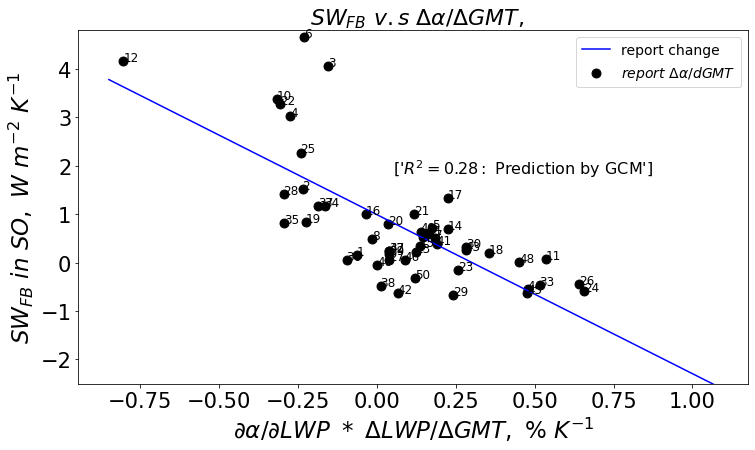

In [26]:
# plot:
parameters = {'axes.labelsize': 23, 'legend.fontsize': 14,
         'axes.titlesize': 22,  'xtick.labelsize': 21,  'ytick.labelsize':21 }
plt.rcParams.update(parameters)

plt.figure( figsize = (12, 6.5))

from scipy.optimize import curve_fit


## data 
# sw_cld_fb from Dr. Mark Zelinka:
SW_FB = []
SW_FB_5085 = []
SW_FB_4050 = []

Y_report_metrics = []
Y_report_metrics_4050 = []
Y_report_metrics_5085 = []

# Y_predicted_metrics = []
# Y_predicted_metrics_4050 = []
# Y_predicted_metrics_5085 = []

Y_OBS_constraint_metrics = []

for i in range(len(deck3)):
    #if (i!= 23) & (i != 27):
    for j in range(len(SO_sw_cldfb)):
        
        if (deck3[i]['modn']== model_nas[j]):
            # if (i in modelconstraintbystep1_nas):
            
            SW_FB = np.append(SW_FB, SO_sw_cldfb[j])
            SW_FB_4050 = np.append(SW_FB_4050, SO_sw_cldfb_4050[j])
            SW_FB_5085 = np.append(SW_FB_5085, SO_sw_cldfb_5085[j])
        
    
for i in range(len(deck3_nas)):
    # if (i in modelconstraintbystep1_nas):
    # Y_predicted_metrics = np.append(Y_predicted_metrics, 100.* output_reconstruct_predicted[deck3_nas[i]])  # convert unit to $%\ K^{-1}$
    # Y_predicted_metrics_4050 = np.append(Y_predicted_metrics_4050, 100.* output_reconstruct_predicted4050[deck3_nas[i]])
    # Y_predicted_metrics_5085 = np.append(Y_predicted_metrics_5085, 100.* output_reconstruct_predicted5085[deck3_nas[i]])
    
    Y_report_metrics = np.append(Y_report_metrics, 100.* output_reconstruct_report[deck3_nas[i]])
    Y_report_metrics_4050 = np.append(Y_report_metrics_4050, 100.* output_reconstruct_report4050[deck3_nas[i]])
    Y_report_metrics_5085 = np.append(Y_report_metrics_5085, 100.* output_reconstruct_report5085[deck3_nas[i]])
    Y_OBS_constraint_metrics = np.append(Y_OBS_constraint_metrics, 100.* output_reconstruct_OBSconstraintonGCM4050[deck3_nas[i]])
    
# SW_FB = np.asarray(SW_FB)
# Y_report_metrics = np.asarray(Y_report_metrics)
# Y_predicted_metrics = np.asarray(Y_predicted_metrics)

# Plotting:

X_metric = Y_report_metrics_4050
Y_metric = SW_FB_4050


plt.scatter(X_metric, Y_metric, marker = 'o', c = 'black', s = 80, label = r'$report\ \Delta \alpha /dGMT$')
# plt.scatter(X_metricq, Y_metricq, marker = 'o', c = 'red', s = 80, label = r'$report\ \Delta \alpha /dGMT$')
# plt.scatter(Y_OBS_constraint_metrics, Y_metric, marker = 7, c = 'tab:blue', s = 94, label = r'$Observational\ constraint$')
# plt.axvspan(x1_min[0], x2_max[0], np.min(Y_metric), np.max(Y_metric), facecolor = 'gray', alpha = 0.6, zorder = 9)

# plt.xlim([-0.25, 0.90]) # [-0.40, 1.20]
plt.ylim([-2.50, 4.80])

plt.xlabel(r"$ \partial \alpha/ \partial LWP\ *\ \Delta LWP/ \Delta GMT,\ \%\ K^{-1} $")
plt.ylabel(r"$ SW_{FB}\ in\ SO,\ W\ m^{-2}\ K^{-1} $")


for j in range(len(deck3)):
    plt.annotate(np.arange(1, 51, 1)[j], xy = (X_metric[j], Y_metric[j]), xytext=(-0.0862, -0.0342), textcoords = "offset points", fontsize = 12)
    # plt.annotate(n_name[j], xy = (X_metric[j], SW_FB_5085[j]), xytext=(-0.056, -0.0342), textcoords = "offset points", fontsize = 12)


# fitting line:
x = np.linspace(-0.85, 1.08, 37)
# x = np.linspace(-0.25, -0.16, 37)  # log-scale
y = np.linspace(-2.50, 4.5, 19)


POPT_SWfb, POCV_SWfb = curve_fit(target_func, X_metric, Y_metric)
fitp1 = plt.plot(x, (POPT_SWfb[0] * x + POPT_SWfb[1]), c = 'b', label = "report change")
# print(POPT_SWfb)

# POPT_SWfbpredi, POCV_SWfbpredi = curve_fit(target_func, Y_predicted_metrics, Y_metric)
# fitp2 = plt.plot(x, (POPT_SWfbpredi[0] * x + POPT_SWfbpredi[1]), c = 'black', label = "fitting line", linewidth = 2.2)

plt.legend(loc = 'best')

plt.title(r"$\ SW_{FB}\ v.s\ \Delta \alpha / \Delta GMT,\ $" + r'')

# plt.annotate([r'$ R^{2} = %.2f :$' % calc_r2(np.asarray(POPT_SWfb[0] * X_metric + POPT_SWfb[1]), Y_metric)+' Prediction by GCM'], xy = (0.85-0.80, 2.13), fontsize = 16)
plt.annotate([r'$ R^{2} = %.2f :$' %pearsonr(Y_report_metrics, Y_metric)[0]**2+' Prediction by GCM'], xy = (0.85-0.80, 2.13- 0.30), fontsize = 16) 
print(np.cov(X_metric, Y_metric))
# plt.show()
print('spearman Correlation coeffcient: ', spearmanr(X_metric, Y_metric))
# print('p value: ', pearsonr(X_metric, Y_metric)[1])
# print('Pearsonr Correlation coeffcient: ', pearsonr(Y_predicted_metrics, SW_FB)[0])
# print('p value: ', pearsonr(Y_predicted_metrics, SW_FB_5085)[1])

# plt.savefig(path6 + "SWfb_vs_Janalphachanges_Oct10th.jpg", bbox_inches = 'tight', dpi = 400)


In [27]:
# Constraint lists of GCMs at different latitude bands: 

list_4085 = []
list_4050 = []
list_5085 = []

for i in range(len(deck3_nas)):
    
    if (Y_report_metrics[i] <= x2_max[0]) &  (Y_report_metrics[i] >= x1_min[0]):
        list_4085.append(i)
    if (Y_report_metrics_4050[i] <= x2_max[1]) &  (Y_report_metrics_4050[i] >= x1_min[1]):
        list_4050.append(i)
    if (Y_report_metrics_5085[i] <= x2_max[2]) &  (Y_report_metrics_5085[i] >= x1_min[2]):
        list_5085.append(i)
    
list_4085 = np.array(list_4085)
list_4050 = np.array(list_4050)
list_5085 = np.array(list_5085)

print(list_4085)
print(list_4050)
print(list_5085)
print(np.min(np.array(SW_FB)[list_4085]), np.max(np.array(SW_FB)[list_4085]))

[ 2  3  5  9 12 14 18 19 21 24 26 31 33 34 35 36 37 38 39 40 45 46 48]
[ 8 12 14 19 20 26 31 38 41 45 46 48 49]
[ 1  2  3  5  8  9 11 12 14 16 19 20 26 31 34 35 37 38 39 40 45 46 48]
-0.9257155717203234 1.527702463828204


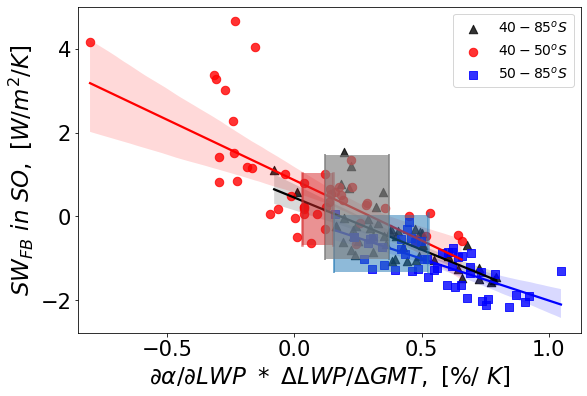

In [29]:
import seaborn as sborn

# sw_cld_fb from Dr. Mark Zelinka:
SW_FB = [None]* len(deck3)
SW_FB_5085 = [None]* len(deck3)
SW_FB_4050 = [None]* len(deck3)

for i in range(len(deck3)):
    # 30
    for j in range(len(SO_sw_cldfb)):
        # 50
        if deck3[i]['modn']== model_nas[j]:
            SW_FB[i] = SO_sw_cldfb[j]
            SW_FB_4050[i] = SO_sw_cldfb_4050[j]
            SW_FB_5085[i] = SO_sw_cldfb_5085[j]
            
plt.figure(figsize = (9, 6))

sborn.regplot(x = Y_report_metrics, y = SW_FB, color = 'black', marker = '^', robust = True, ci = 95, scatter_kws={"s": 72}, label = r'$40 - 85^{o}S$')
sborn.regplot(x = Y_report_metrics_4050, y = SW_FB_4050, color = 'red', marker = 'o', robust = True, ci = 95, scatter_kws={"s": 72}, label = r'$40 - 50^{o}S$')
sborn.regplot(x = Y_report_metrics_5085, y = SW_FB_5085, color = 'blue', marker = 's', robust = True, ci = 95, scatter_kws={"s": 72}, label = r'$50 - 85^{o}S$')

plt.axvspan(x1_min[0], x2_max[0], 0.225, 0.545, facecolor = 'gray', alpha = 0.65, zorder = 96)
plt.axvspan(x1_min[1], x2_max[1], 0.270, 0.49, facecolor = 'tab:red', alpha = 0.50, zorder = 95)
plt.axvspan(x1_min[2], x2_max[2], 0.1850, 0.36085, facecolor = 'tab:blue', alpha = 0.50, zorder = 94)

plt.axvline(x1_min[0], 0.225, 0.545, c = 'gray', alpha = 0.75, linewidth = 2.)
plt.axvline(x2_max[0], 0.225, 0.545, c = 'gray', alpha = 0.75, linewidth = 2.)
plt.axvline(x1_min[1], 0.270, 0.49, c = "tab:red", alpha = 0.60, linewidth = 2.5)
plt.axvline(x2_max[1], 0.270, 0.49, c = "tab:red", alpha = 0.60, linewidth = 2.5)
plt.axvline(x1_min[2], 0.1850, 0.3685, c = "tab:blue", alpha = 0.60, linewidth = 2.)
plt.axvline(x2_max[2], 0.1850, 0.3685, c = "tab:blue", alpha = 0.60, linewidth = 2.5)

plt.xlim([-0.85, 1.125])
plt.ylabel(r"$ SW_{FB}\ in\ SO,\ [W/ m^{2}/ K] $") 
plt.xlabel(r"$ \partial \alpha/ \partial LWP\ *\ \Delta LWP/ \Delta GMT,\ [\%/\ K] $")
plt.legend()

# plt.savefig(path6 + "SWFBv.sDeltaalbedo_Jan_DeltaLWP_DeltaGMT_predictedchange_Nov2nd.jpg", bbox_inches = 'tight', dpi = 400)
# plt.savefig(path6 + "Fig8_addLat4050.jpg", bbox_inches = 'tight', dpi = 450)

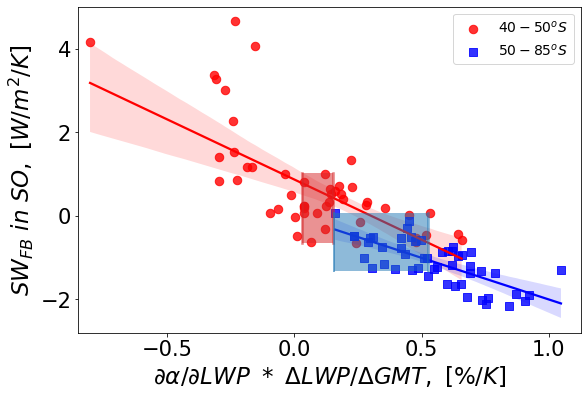

In [28]:
import seaborn as sborn

# sw_cld_fb from Zelinka:
SW_FB = [None]* len(deck3)
SW_FB_5085 = [None]* len(deck3)
SW_FB_4050 = [None]* len(deck3)

for i in range(len(deck3)):
    # 30
    for j in range(len(SO_sw_cldfb)):
        # 50
        if deck3[i]['modn']== model_nas[j]:
            SW_FB[i] = SO_sw_cldfb[j]
            SW_FB_4050[i] = SO_sw_cldfb_4050[j]
            SW_FB_5085[i] = SO_sw_cldfb_5085[j]
            
plt.figure(figsize = (9, 6))

# sborn.regplot(x = Y_report_metrics, y = SW_FB, ci = 95, color = 'black', marker = '^', ci = 95, scatter_kws={"s": 72}, label = r'$40 - 85^{o}S$')
sborn.regplot(x = Y_report_metrics_4050, y = SW_FB_4050, robust= True, ci = 95, x_ci = 'ci', color = 'red', marker = 'o', scatter_kws={"s": 72}, label = r'$40 - 50^{o}S$')
sborn.regplot(x = Y_report_metrics_5085, y = SW_FB_5085, robust= True, ci = 95, x_ci = 'ci', color = 'blue', marker = 's', scatter_kws={"s": 72}, label = r'$50 - 85^{o}S$')

# plt.axvspan(x1_min[0], x2_max[0], 0.245, 0.574, facecolor = 'gray', alpha = 0.65, zorder = 96)
plt.axvspan(x1_min[1], x2_max[1], 0.2746, 0.489, facecolor = 'tab:red', alpha = 0.50, zorder = 97)
plt.axvspan(x1_min[2], x2_max[2], 0.190, 0.367, facecolor = 'tab:blue', alpha = 0.50, zorder = 98)

# plt.axvline(x1_min[0], 0.2465, 0.5695, c = 'gray', alpha = 0.75, linewidth = 2.)
# plt.axvline(x2_max[0], 0.2465, 0.5695, c = 'gray', alpha = 0.75, linewidth = 2.)
plt.axvline(x1_min[1], 0.2746, 0.489, c = "tab:red", alpha = 0.60, linewidth = 2.5)
plt.axvline(x2_max[1], 0.2746, 0.489, c = "tab:red", alpha = 0.60, linewidth = 2.5)
plt.axvline(x1_min[2], 0.190, 0.367, c = "tab:blue", alpha = 0.60, linewidth = 2.)
plt.axvline(x2_max[2], 0.190, 0.367, c = "tab:blue", alpha = 0.60, linewidth = 2.5)

plt.xlim([-0.85, 1.125])

plt.ylabel(r"$ SW_{FB}\ in\ SO,\ [W/ m^{2}/ K] $")
plt.xlabel(r"$ \partial \alpha/ \partial LWP\ *\ \Delta LWP/ \Delta GMT,\ [\%/ K] $")
plt.legend()

# plt.savefig(path6 + "SWFBv.sDeltaalbedo_Jan_DeltaLWP_DeltaGMT_predictedchange_Nov2nd.jpg", bbox_inches = 'tight', dpi = 400)
plt.savefig(path_plot + "Fig_8.jpg", bbox_inches = 'tight', dpi = 500)

<AxesSubplot:>

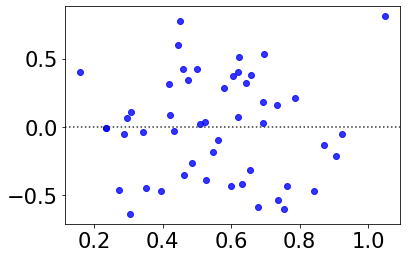

In [30]:
sborn.residplot(x=Y_report_metrics_5085, y=SW_FB_5085, lowess=False, order=1, robust=True, color= 'blue', scatter_kws=None, line_kws=None, ax=None)

<AxesSubplot:>

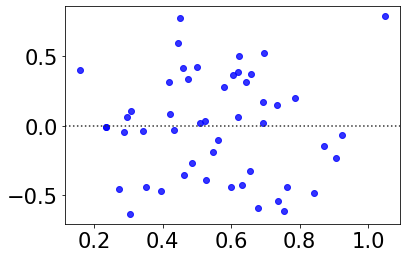

In [31]:
sborn.residplot(x=Y_report_metrics_5085, y=SW_FB_5085, lowess=False, order=1, robust=False, color= 'blue', scatter_kws=None, line_kws=None, ax=None)